In [10]:
import shap
import numpy as np
import pandas as pd
import sklearn.svm as svm
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [11]:
gesture = ["Down", "Up", "Left", "Right"]
path = "HeadData/"
gyro = "/gyro/"
features = 6
trials = 40
x = [[0] * features for i in range(trials * len(gesture))]
y = [0] * trials * len(gesture)

In [12]:
def min_max_feature_order(s1, s2):
    if s1 > s2:
        return 1
    else:
        return 5

# Feature Extraction and Labelling (Slide 70 Demo-1, Slide 72 Demo-2)
Below shows the features that are declared, and their extraction process for all of the 
data

In [13]:
for i in range(0, len(gesture), 1): # i is the nominal value of the class Gesture which takes values 0,1,2,3 for Down, Up, Left, Right
    for k in range(0, trials, 1):
        path_data = path + gesture[i] + gyro + "trial" + str(k + 1) + ".csv"
        data = genfromtxt(path_data, delimiter=",")
        # Features
        x[k + i * trials][0] = min_max_feature_order(np.argmax(data[:, 1]), np.argmin(data[:, 1]))
        x[k + i * trials][1] = min_max_feature_order(np.argmax(data[:, 3]), np.argmin(data[:, 3]))
        x[k + i * trials][2] = min_max_feature_order(np.argmax(data[:, 2]), np.argmin(data[:, 2]))
        x[k + i * trials][3] = min(data[:, 1])  # down up gestures the x dimension changes the most
        x[k + i * trials][4] = min(data[:, 3])  # right left gestures the z dimension changes the most
        x[k + i * trials][5] = min(data[:, 2])
        # x[k+i*trials][4]=max(data[:,1]) # down up gestures the x dimension changes the most
        # x[k+i*trials][5]=max(data[:,3]) # right left gestures the z dimension changes the most
        # x[k+i*trials][6]=data[:,1].mean() # mean for x dimension
        # x[k+i*trials][7]=data[:,3].mean() # mean for z dimension
        # x[k+i*trials][8]=data[:,1].std() # std for x dimension
        # x[k+i*trials][9]=data[:,3].std() # std for z dimension
        # target variables
        y[[k + i * trials][0]] = i
numpy_x = np.array(x)
numpy_y = np.array(y)

In [14]:
# Micro-averaging can be more influenced by the performance of the larger classes, whereas macro-averaging treats all classes equally.
# Micro-averaging may be more appropriate when you are dealing with imbalanced datasets or when you are more interested in the overall performance of the model. 
# Macro-averaging can be useful when you want to evaluate the model's performance on smaller classes.
def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    return cm, accuracy, precision, recall, f1

# Training With All the Data (Including all the features)

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


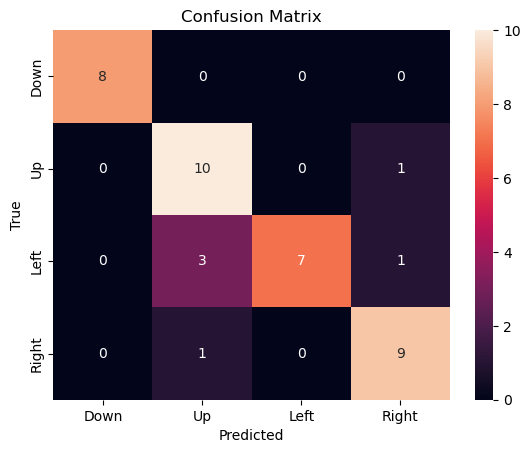

In [15]:
X_train, X_test, y_train, y_test = train_test_split(numpy_x, numpy_y, test_size=0.25, random_state=0)
clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))
y_pred = clf.predict(X_test)
cm, accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# For feature selection, we use Shapley Values. We plot them below to see which features are the most important.

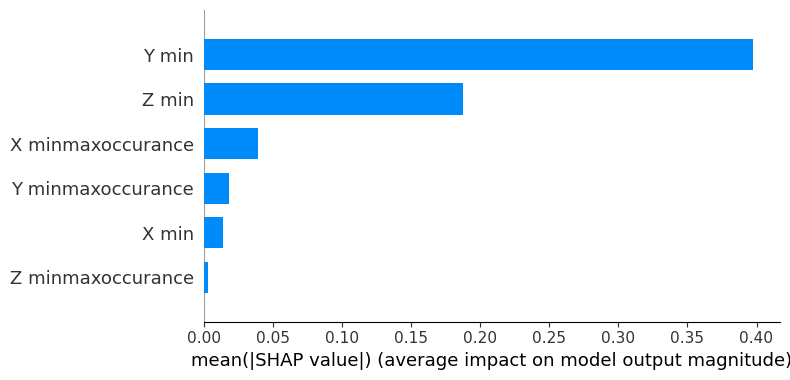

In [16]:
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)

explainer = shap.Explainer(clf, X_train)
shap_values_individual = explainer.shap_values(X_test)
shap_values = np.mean(shap_values_individual, axis=1)
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]
target_names = ["Down", "Up", "Left", "Right"]
shap.summary_plot(shap_values, plot_type="bar", class_names=target_names, feature_names=feature_names)

# We see that most important Top-3 features are at indices of [0, 4, 5] in feature_names list. Let's see what is the accuracy when we use only top-3 features.

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1 Score: 0.8000000000000002


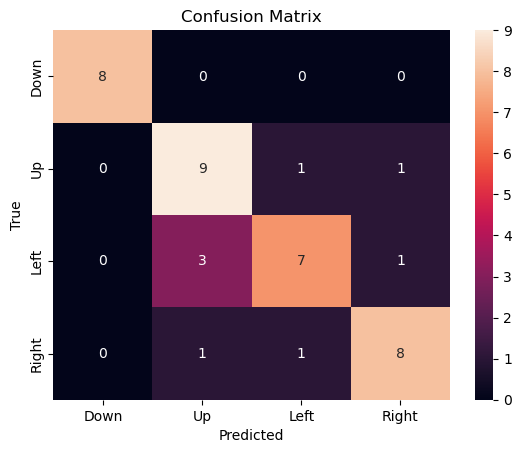

In [17]:
X_train, X_test, y_train, y_test = train_test_split(numpy_x, numpy_y, test_size=0.25, random_state=0)
X_train = X_train[:, [0, 4, 5]]
X_test = X_test[:, [0, 4, 5]]
clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))
y_pred = clf.predict(X_test)
cm, accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Just 0.05 reduction in accuracy! Not bad!

# Now We see that least important Top-3 features are at indices of [1, 2, 3] in feature_names list. Let's see what the accuracy will be if we only use these features.

Accuracy: 0.45
Precision: 0.45
Recall: 0.45
F1 Score: 0.45


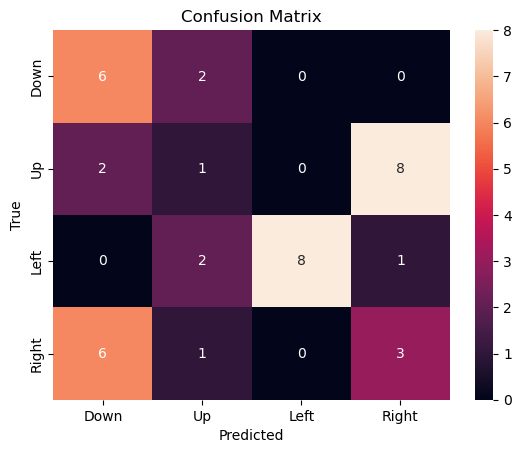

In [18]:
X_train, X_test, y_train, y_test = train_test_split(numpy_x, numpy_y, test_size=0.25, random_state=0)
X_train = X_train[:, [1, 2, 3]]
X_test = X_test[:, [1, 2, 3]]
clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))
y_pred = clf.predict(X_test)
cm, accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Ouch! That hurt the Accuracy! We see that the accuracy dropped. This is because the features that we removed were actually important for the model to learn the patterns in the data.